In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('merged_training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Text     416809 non-null  object
 1   Emotion  416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [3]:
df.Emotion.value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: Emotion, dtype: int64

In [4]:
df = df.loc[(df["Emotion"]!="surprise")]
df = df.loc[(df["Emotion"]!="love")]

In [5]:
df.Emotion.value_counts()

joy        141067
sadness    121187
anger       57317
fear        47712
Name: Emotion, dtype: int64

In [6]:
features = []
target = []

counter_happy = 0
counter_sad = 0

for i in range(len(df)):
    if df["Emotion"].iloc[i] == "joy":
        if counter_happy < 50000:
            features.append(df["Text"].iloc[i])
            target.append(df["Emotion"].iloc[i])
            counter_happy+=1
    elif df["Emotion"].iloc[i] == "sadness":
        if counter_sad < 50000:
            features.append(df["Text"].iloc[i])
            target.append(df["Emotion"].iloc[i])
            counter_sad+=1
    else:
        features.append(df["Text"].iloc[i])
        target.append(df["Emotion"].iloc[i])

In [7]:
features = np.array(features)
target = np.array(target)

In [8]:
print(target.shape)

(205029,)


In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [10]:
for i in range(len(features)):
    features[i] = clean_text(features[i])

In [11]:
print(features)

['feel awful job get position succeed happen' 'im alone feel awful'
 'ive probably mentioned really feel proud actually keeping new years resolution monthly weekly goals'
 ...
 'im tired little irrational wearing much makeup sometimes feel insecure'
 'could never bear feeling violent thought'
 'take every day comes focussing eating better moment aiming unrealistic targets setting deadlines feel pressured improving diet']


In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 30
# This is fixed.
EMBEDDING_DIM = 150
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 52621 unique tokens.


In [13]:
features = tokenizer.texts_to_sequences(features)
features = pad_sequences(features, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', features.shape)

Shape of data tensor: (205029, 30)


In [14]:
target = np.reshape(target, (-1, 1))
target = OneHotEncoder(sparse=False).fit_transform(target)
target.shape

(205029, 4)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features,target, test_size = 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(164023, 30) (164023, 4)
(41006, 30) (41006, 4)


In [16]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, CuDNNLSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(CuDNNLSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2307/2307 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9506WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000284054F9948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

In [17]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1282/1282 [==============================] - 6s 4ms/step - loss: 0.0786 - accuracy: 0.9642
Test set
  Loss: 0.079
  Accuracy: 0.964


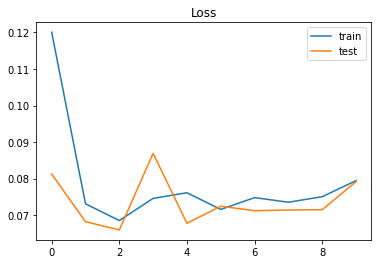

In [18]:
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

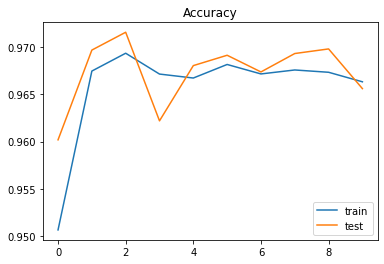

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [20]:
from sklearn.metrics import confusion_matrix
test = model.predict(X_test)
test = np.argmax(test, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print(confusion_matrix(test, Y_test))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[11369   581    74   278]
 [   52  8762    16    91]
 [   32    45  9811    34]
 [   37   202    27  9595]]
